In [ ]:
#Import packages
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from PIL import Image
from torch import optim
device='cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob 
!pip install torch_summary
from torchsummary import summary
import random
import os
import shutil
import numpy as np
from google.colab import files
import zipfile
import pandas as pd
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset

In [ ]:
! pip install -q kaggle

! pip install --upgrade --force-reinstall --no-deps kaggle

files.upload()

     |████████████████████████████████| 58 kB 2.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=c4e32edd7c86f328fa0e350a358ca9ad004b77debcd4c79b2654ba234b5b5332
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emmagamble","key":"d7d47782414afd65e498e1a4d2221bf8"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [02:19<00:00, 79.0MB/s]
100% 6.31G/6.31G [02:19<00:00, 48.4MB/s]


In [ ]:
zip = zipfile.ZipFile('histopathologic-cancer-detection.zip')

zip.extractall()

In [ ]:
# See image count in each folder
print(len(os.listdir('../content/train')))
print(len(os.listdir('../content/test')))

220025
57458


In [ ]:
# Create a Dataframe containing all images
# One column has the image ids, while the other has the label (0 for no cancer, and 1 for cancer)

data = pd.read_csv('../content/train_labels.csv')

# Removing this image because it causes a training error
data[data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# Removing this image because it's black
data[data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

data.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
df_data = pd.read_csv('../content/train_labels.csv')

# Check the class distribution

print(df_data['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


In [ ]:
IMAGE_SIZE = 96 #we have 96x96 images
IMAGE_CHANNELS = 3 #rgb images
SAMPLE_SIZE = 80000 # the number of images we use from each of the two classes

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [ ]:
#Seperate data into train, validation and test datasets
df_train, df_val, df_test = np.split(df_data.sample(frac=1), [int(.6*len(df_data)), int(.8*len(df_data))])

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

df_train.head()

(96000, 2)
(32000, 2)
(32000, 2)


,id,label
37939,4725ae2a4046e97a1e3f6e8407f827cb2cc9dca8,0
28847,e7aac64fe2fa28dea114ce588ce234ee780e4f66,0
104017,9b884c8ceb28afb58cc122ec4fffbb61c1e25644,1
59090,1b284eb878e57c5b0bcb5400451bccf0c0933697,0
29289,7713d350650d3fedb83ea2f95c0b0e803441bd30,0


In [ ]:
# Check the training set counts
df_train['label'].value_counts()
#Check the test set counts
df_test['label'].value_counts()
# Check the validation set counts
df_val['label'].value_counts()

0    16061
1    15939
Name: label, dtype: int64

In [ ]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]
# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue
    
# test_dir
    # a_no_tumor_issue
    # b_has_tumor_issue
    
# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue
    
# create a path to 'base_dir' to which we will join the names of the new folders

# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# test_dir
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


#create new folders inside test_dir
no_tumor_tissue = os.path.join(test_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(test_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [ ]:
# (experiment)check that the folders have been created
print(os.listdir('gdrive/My Drive/Colab Notebooks/base_dir/train_dir'))
print(os.listdir('gdrive/My Drive/Colab Notebooks/base_dir/test_dir'))
print(os.listdir('gdrive/My Drive/Colab Notebooks/base_dir/val_dir'))

In [ ]:
# check that the folders have been created
print(os.listdir('base_dir/train_dir'))
print(os.listdir('base_dir/test_dir'))
print(os.listdir('base_dir/val_dir'))

['a_no_tumor_tissue', 'b_has_tumor_tissue']
['a_no_tumor_tissue', 'b_has_tumor_tissue']
['a_no_tumor_tissue', 'b_has_tumor_tissue']


In [ ]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

# Get a list of train and val images
train_list = list(df_train['id'])
test_list = list(df_test['id'])
val_list = list(df_val['id'])


# Transfer the train images
count = 0
for image in train_list:
    count += 1
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']

    # these must match the folder names
    if target.any() == 0:
        label = 'a_no_tumor_tissue'
    if target.any() == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('../content/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the test images
for image in test_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target.any() == 0:
       label = 'a_no_tumor_tissue'
    if target.any() == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('../content/train', fname)
    # destination path to image
    dst = os.path.join(test_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target.any() == 0:
        label = 'a_no_tumor_tissue'
    if target.any() == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('../content/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [ ]:
# check how many train images we have in each folder
print("Number of training images in the no cancer and cancer folders respectively")
print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))

# check how many test images we have in each folder
print("Number of test images in the no cancer and cancer folders respectively")
print(len(os.listdir('base_dir/test_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/test_dir/b_has_tumor_tissue')))

# check how many val images we have in each folder
print("Number of validation images in the no cancer and cancer folders respectively")
print(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))

Number of training images in the no cancer and cancer folders respectively
48045
47955
Number of test images in the no cancer and cancer folders respectively
15894
16106
Number of validation images in the no cancer and cancer folders respectively
16061
15939


In [ ]:
train_data_dir = 'base_dir/train_dir'
val_data_dir = 'base_dir/val_dir'
test_data_dir = 'base_dir/test_dir'

In [ ]:
class cancer(Dataset):
  def __init__(self, folder):
    tumour = glob(folder+'/b_has_tumor_tissue/*.tif') 
    no_tumour = glob(folder+'/a_no_tumor_tissue/*.tif')  
    self.fpaths = tumour + no_tumour
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-2].startswith('a') for fpath in self.fpaths] # no_tumour=1 & tumour=0
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

tensor([0.], device='cuda:0')


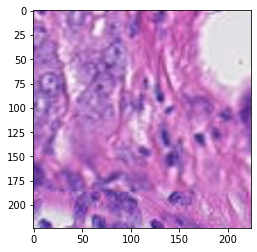

In [ ]:
#inspect a random image
data = cancer(train_data_dir)
im, label = data[3]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
#Define a model, loss function and optimizer
def conv_layer(ni,no,kernal_size, stride=1):
  return nn.Sequential(
      nn.Dropout(p=0.2),
      nn.Conv2d(ni,no,kernal_size,stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

def get_model():
  model=nn.Sequential(
      conv_layer(3,64,3),
      conv_layer(64,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      nn.Flatten(),
      nn.Dropout(p=0.2),
      nn.Linear(512,1),
      nn.Sigmoid(),
  ).to(device)
  loss_fn=nn.BCELoss()
  optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

from torchsummary import summary
model, loss_fn, optimizer=get_model()
summary(model, torch.zeros(1,3,224,224));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Dropout: 2-1                      [-1, 3, 224, 224]         --
|    └─Conv2d: 2-2                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-3                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-4                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-5                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Dropout: 2-6                      [-1, 64, 111, 111]        --
|    └─Conv2d: 2-7                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-8                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-9                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-10                   [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction=model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item() 

In [ ]:
@torch.no_grad()
def accuracy(x,y, model):
  prediction=model(x)
  is_correct=(prediction>0.5)==y
  return is_correct.cpu().numpy().tolist()

In [ ]:
def get_data():     
    train = cancer(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = cancer(val_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [ ]:
@torch.no_grad()
def val_loss(x, y, model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
val_epoch_accuracy_max=0.00
num_epochs=5
for epoch in range(num_epochs):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    print("train accuracy=",train_epoch_accuracy)
    print("validation accuracy=",val_epoch_accuracy)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    # save model if validation loss has decreased
    #if val_epoch_accuracy >= val_epoch_accuracy_max:
     #  print('Validation accuracy increased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      #  val_epoch_accuracy_max,
       # val_epoch_accuracy))
        #torch.save(model.state_dict(), 'gdrive/My Drive/Colab Notebooks/base_dir/saved_model')
        #v#al_epoch_accuracy_max = val_epoch_accuracy


In [ ]:
    test = cancer(test_data_dir)
    test_dl = DataLoader(test, batch_size=32, shuffle=True, drop_last = True)

In [ ]:
test_accuracies=[]  
for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        #print(ix, is_correct)
        test_accuracies.extend(is_correct)
test_accuracy = np.mean(test_accuracies)
print(test_accuracy)

0.8941875


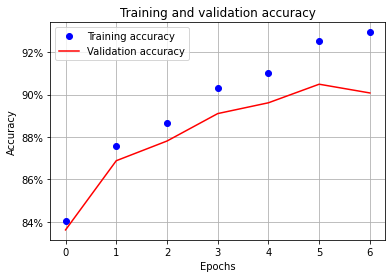

In [ ]:
epochs = range(num_epochs)
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo',
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r',
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()